<center><h1><strong>WeRateDogs Data Wrangling</strong></h1></center>

# Introduction

This project started as an assessment for for the **Udacity Data Analysis Professional Track**.

The dataset is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as 
[WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because ["they're good dogs Brent."](https://knowyourmeme.com/memes/theyre-good-dogs-brent) WeRateDogs has over 4 million followers and has received international media coverage.

<center><img width="50%" src ="dog-rates-social.jpg"/></center>

# 1. Gathering

Three sources of data were gathered for this Project:

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import tweepy
import json
import re

## 1.1 The WeRateDogs Twitter Archive

- The 'twitter-archive-enhanced.csv' file was provided by Udacity and downloaded manually.
- Then it was easily read into a pandas DataFrame `df_archive`.

In [2]:
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


## 1.2 The Tweet image predictions

- The 'image-predictions.tsv' shows the results of a neural network that detects what breed of dog (or other object, animal, etc.) is present in each tweet.   
- The file was downloaded programmatically using the Requests python library and then saved to a local file with the same name.
- The file was then read into a pandas DataFrame `df_pred` while specifying that it's a tsv by setting the `sep` parameter to `'\t'`.

In [3]:
# Download image predictions file if it doesn't exist
pred_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = pred_url.split('/')[-1]

if os.path.exists(file_name):
    print(f"File {file_name} already exists")
else:
    r = requests.get(pred_url)
    # write the reponse to a local file
    with open('image-predictions.tsv','wb') as file:
        file.write(r.content)
        print(f"successfully downloaded {file_name} and written to disc")

File image-predictions.tsv already exists


In [4]:
# Read the image predictions file into a DataFrame
df_pred = pd.read_csv('image-predictions.tsv',sep='\t')
df_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## 1.3 Twitter API 

- A Twitter Developer account was created and used to qurey more data using the tweet ids from the `df_archive` DataFrame.
- The Twitter API was used to query each tweet's JSON data using Python's Tweepy library and stored each tweet's entire set of JSON data as a line in a file called tweet_json.txt file.
- The 'tweet._json.txt' file line by line into a pandas DataFrame `df_api` with the following columns:
    - tweet ID.
    - retweet count. 
    - favorite count. 

- Note: Twitter API keys, secrets, and tokens were read from an external file and were not submitted with the project.

In [5]:
tweet_ids = df_archive['tweet_id']
json_file = 'tweet_json.txt'


# only Query the API if the tweet_json.txt file doesn't exist
if os.path.exists(json_file):
    print(f"File {json_file} already exists")
else:
    # import the keys files where the API keys are stored and it is not submitted with the project
    import keys
    # Twitter API authorization 
    auth = tweepy.OAuthHandler(keys.consumer_key, keys.consumer_secret)
    auth.set_access_token(keys.access_token, keys.access_secret)

    api = tweepy.API(auth)
    
    count = 0
    fails_dict = {}
    # Save each tweet's returned JSON as a new line in a .txt file
    with open(json_file, 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    print(f"File {json_file} successfully written to Disk")
    print("Some tweets returned the following errors")
    print(fails_dict)



File tweet_json.txt already exists


In [6]:
# read .txt file line by line into a pandas DataFrame

labels = ['tweet_id','retweet_count','favorite_count']

df_api = pd.DataFrame(columns=labels)

with open(json_file) as file:
    for line in file:
        data = json.loads(line)
        df_api = df_api.append({
            'tweet_id':data['id'],
            'retweet_count':data['retweet_count'],
            'favorite_count':data['favorite_count']
            },ignore_index=True)
        
df_api.sample(5)

,tweet_id,retweet_count,favorite_count
376,826115272272650244,3040,15435
254,841833993020538882,14473,0
922,679132435750195208,1112,2882
392,823581115634085888,2583,12875
1090,674330906434379776,71,538


## 1.4 Gathering Output
 
The three files were successfully downloded, written to a local file and read into the following pandas DataFrames:
- `df_archive` : Data from the WeRateDogs Twitter archive.
- `df_pred` : Data from the image predictions from the neural network.
- `df_api` : Data scraped from the Twitter API.


# 2. Assessing the Data

## 2.1 Twitter Archive

In [7]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
df_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
623,796031486298386433,NaN,NaN,2016-11-08 16:47:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Daisy. She's here to make your day bet...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/796031486...,13,10,Daisy,None,None,None,None
773,776249906839351296,NaN,NaN,2016-09-15 02:42:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. Pls stop sen...,7.007478e+17,4.196984e+09,2016-02-19 18:24:26 +0000,https://twitter.com/dog_rates/status/700747788...,11,10,very,None,None,None,None
1947,673700254269775872,NaN,NaN,2015-12-07 03:07:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Large blue dog here. Cool shades. Flipping us ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673700254...,3,10,None,None,None,None,None
428,821149554670182400,NaN,NaN,2017-01-17 00:18:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Luca. He got caught howling. H*ckin em...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/821149554...,12,10,Luca,None,None,None,None
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [9]:
# check for duplicated entries
sum(df_archive['tweet_id'].duplicated())

0

In [10]:
df_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [11]:
df_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [12]:
names = df_archive['name'].value_counts().keys()
not_names = []

for name in names:
    if name.islower() or len(name) < 2:
        not_names.append(name)
print(not_names)

['a', 'the', 'an', 'very', 'just', 'one', 'quite', 'mad', 'actually', 'not', 'getting', 'O', 'light', 'this', 'my', 'incredibly', 'by', 'officially', 'all', 'infuriating', 'space', 'life', 'such', 'unacceptable', 'his', 'old']


In [13]:
df_archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [14]:
df_archive[['doggo','floofer','pupper','puppo']].value_counts()

doggo  floofer  pupper  puppo
None   None     None    None     1976
                pupper  None      245
doggo  None     None    None       83
None   None     None    puppo      29
doggo  None     pupper  None       12
None   floofer  None    None        9
doggo  floofer  None    None        1
       None     None    puppo       1
dtype: int64

In [15]:
df_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

## 2.2 Tweet Image Predictions

In [16]:
df_pred.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1848,839549326359670784,https://pbs.twimg.com/media/C6atpTLWYAIL7bU.jpg,1,swing,0.393527,False,Norwich_terrier,0.052480,True,Pembroke,0.049901,True
478,675334060156301312,https://pbs.twimg.com/media/CV9EvZNUwAAgLCK.jpg,2,Pembroke,0.773135,True,Cardigan,0.116810,True,chow,0.039036,True
268,670811965569282048,https://pbs.twimg.com/media/CU8z65IUEAQBc4q.jpg,1,basset,0.994090,True,Walker_hound,0.003973,True,beagle,0.001406,True
88,667530908589760512,https://pbs.twimg.com/media/CUOL0uGUkAAx7yh.jpg,1,golden_retriever,0.633037,True,kuvasz,0.146391,True,Labrador_retriever,0.046184,True
89,667534815156183040,https://pbs.twimg.com/media/CUOPYI5UcAAj_nO.jpg,1,Pembroke,0.435254,True,Cardigan,0.307407,True,cocker_spaniel,0.033158,True


In [17]:
sum(df_pred['tweet_id'].duplicated())

0

In [18]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
df_pred['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

## 2.3 Twitter API

In [20]:
df_api

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7461,35352
1,892177421306343426,5537,30593
2,891815181378084864,3664,23025
3,891689557279858688,7637,38647
4,891327558926688256,8228,36916
...,...,...,...
1527,666049248165822465,39,95
1528,666044226329800704,124,264
1529,666033412701032449,39,108
1530,666029285002620928,41,118


In [21]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532 entries, 0 to 1531
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        1532 non-null   object
 1   retweet_count   1532 non-null   object
 2   favorite_count  1532 non-null   object
dtypes: object(3)
memory usage: 36.0+ KB


## 2.4 Assesing Output

### Quality

#### Completeness: 
do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?

`df_archive`
- 'expanded_urls' have missing values. taht means they don't have image information.

`df_api`
- The API query failed to retrieve data for 25 tweets because they are either no longer available or access is denied.


#### Validity: 
we have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).

`df_archive`

- The 'is_reply_status_id' and 'retweeted_status_id' columns have non null values showing that 181 entries are retweets and 78 entries are replies. i.e; not original retweets.
- Also 'expanded_urls' have missing values which means they don't contain images.

#### Accuracy: 
inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.

`df_archive`

- the 'name' column has some values that are not actual name. such as:  
'a', 'the', 'an', 'very', 'one', 'quite', 'just', 'mad', 'actually', 'getting', 'not', 'infuriating', 'space', 'unacceptable', 'his', 'old', 'O', 'life', 'this', 'incredibly', 'such', 'light', 'officially', 'all', 'by', 'my'.
- 12 entries have both lables 'doggo' and 'pupper'
- 1 entry have both labels 'doggo' and 'floofer

#### Consistency: 
inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

`df_archive`
- not all 'rating_denominator' values are 10.
- The 'rating_numerator' column has some very low or very large values.
- 'timestamp' and 'retweeted_status_timestamp' column is has type of srting. should be datetime.
- the 'source' column values are the complete 'a' tag. Should be reduced to only be actual source values:  
    iPhone, Vine, Web Client and TweetDeck
- The 'name' columns missing values are labeled 'None'.

`df_api`
- the 'tweet_id', 'retweet_count' and 'favorite_count' are of type string. Should be integers.


### Tidiness

`df_archive`
- The dog stages columns ('doggo', 'flooofer', 'pupper', 'puppo') should be one column instead.

`df_pred`
- Multiple predictions exist in the same row. the doean't follow the tisiness rule 'every row is an observation'. Each prediction should be its own row instead.

`df_api`
- The observation row here is the tweet defined by the 'tweet_id' that is the same as in `df_archive`. The two tables should be one table instead. 

# 3. Clean

## 3.1 Twitter Archive

In [52]:
#Copying the original DataFrame into a new one to be cleaned
df_archive_clean = df_archive.copy()

#### Define
* Convert the 'timestamp' and 'retweeted_status_timestamp' columns from string to datetime using the `pd.to_datetime` function.

#### Code

In [53]:
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])
df_archive_clean['retweeted_status_timestamp'] = pd.to_datetime(df_archive_clean['retweeted_status_timestamp'])

#### Test

In [54]:
# check that the 'timestamp' and 'retweeted_status_timestamp' columns are changed to datetime
df_archive_clean[['timestamp','retweeted_status_timestamp']].dtypes

timestamp                     datetime64[ns, UTC]
retweeted_status_timestamp    datetime64[ns, UTC]
dtype: object

#### Define

* Remove all tweets that are not orignal tweets, i.e; tweets that are retweets or replies. So, the `df_archive_clean` is filtered to only the rows where the columns 'retweeted_status_id' and 'in_reply_to_status_id' are null values.

#### Code

In [55]:
df_archive_clean = df_archive_clean[df_archive_clean['retweeted_status_id'].isnull()]
df_archive_clean = df_archive_clean[df_archive_clean['in_reply_to_status_id'].isnull()]

#### Test

In [56]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2097 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2097 non-null   datetime64[ns, UTC]
 4   source                      2097 non-null   object             
 5   text                        2097 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      datetime64[ns, UTC]
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2097 non-null   int64           

#### Define

* Remove the rows with empty 'expanded_urls'. These are the tweets that don't have image information.

#### Code

In [57]:
df_archive_clean = df_archive_clean[df_archive_clean['expanded_urls'].notna()]

#### Test

In [58]:
sum(df_archive_clean['expanded_urls'].isnull())

0

#### Define

- Remove the columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp' as they are no longer relevant

#### Code

In [59]:
cols = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp',]

df_archive_clean.drop(cols, axis=1, inplace=True)

#### Test

In [60]:
df_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

#### Define

* Combine the dog stages columns ('doggo', 'flooofer', 'pupper', 'puppo') should be one column 'dog_stage' instead. This was done by appliyng a custom funcion `dog_stage` to the whole DataFrame that returns the interpreted dog_stage and convert the 'None' string to a null value
* for cases where 'doggo' and other value exist. 'doggo' will be chosen as 'doggo' is the older dog and dogs can only grow up. So, 'doggo' will definetly be the more valid value.

#### Code

In [61]:
def dog_stage(row):
    """
    Returns the dog stage based on the values of other columns
    """
    stages = ['doggo','floofer','pupper','puppo']
    for stage in stages:
        if row[stage].lower().strip() == stage:
            return stage
    return np.NaN

df_archive_clean['dog_stage'] = df_archive_clean.apply(lambda x: dog_stage(x), axis=1)

#### Test

In [62]:
df_archive_clean['dog_stage'].value_counts(dropna=False)

NaN        1759
pupper      220
doggo        83
puppo        23
floofer       9
Name: dog_stage, dtype: int64

#### Define

* Remove the  columns ('doggo', 'floofer', 'pupper', 'puppo') as they are no longer relevant and now combined into one column `dog_stage`

#### Code

In [63]:
cols = ['doggo', 'floofer', 'pupper', 'puppo']

df_archive_clean.drop(cols, axis=1, inplace=True)

#### Test

In [64]:
df_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

#### Define

- Fixing the 'rating_numerator' and 'rating_denominator' columns by addressing the possible error causes:
    - for the pack of dogs, the raing denominator is usually a multiple of 10. if that's the case, a factor is calculated to return the rating back to the base of 10.
    - for the errors in extractions of data when the text sontains more than one '/' character. The text is searched using regex for a valid rating with a denominator of 10 and then the rating numerator and denominator are extracted as a result.
    - if there's only one '/' character in the text, a base rating is assumed of 10/10.
    - for the decimal point ratings, the integer value before the decimal point is extracted and considered as the valid rating numerator.
    - only two teets were left with exceptional high scores. They were not changes as they were valid ratings. One for a real dog and another for the famous artist "Snoop Dog". 

#### Code

In [65]:
def fix_rating(row):
    if row['rating_denominator'] != 10:
        if row['rating_denominator'] % 10 ==0:
            num = row['rating_denominator']/10
            row['rating_numerator']=int(row['rating_numerator']/num)
            row['rating_denominator'] = 10
        else:
            prog = re.compile('../..')
            results = re.findall(prog, row['text'])
            for result in results:
                if result[-2:] == '10':
                    row['rating_numerator']= int(result[:2])
                    row['rating_denominator'] = 10
                    results.remove(result)
            if len(results):
                row['rating_numerator']= 10
                row['rating_denominator'] = 10
                
    else:
        prog = re.compile('\d*\.\d*/10')
        results = re.findall(prog, row['text'])
        for result in results:
            if result[-2:] == '10':
                try:
                    row['rating_numerator'] = int(result.split('.')[0].strip())
                except:
                    row['rating_numerator'] = 10
        
    
    return row

    
df_archive_clean = df_archive_clean.apply(lambda x: fix_rating(x), axis=1)

df_archive_clean[['tweet_id','text','rating_numerator','rating_denominator']].query('rating_numerator > 20 or  rating_denominator !=10')

,tweet_id,text,rating_numerator,rating_denominator
979,749981277374128128,This is Atticus. He's quite simply America af....,1776,10
2074,670842764863651840,After so many requests... here you go.\n\nGood...,420,10


#### Test

In [66]:
df_archive_clean['rating_denominator'].value_counts()

10    2094
Name: rating_denominator, dtype: int64

In [67]:
df_archive_clean['rating_numerator'].value_counts()

12      487
10      451
11      416
13      287
9       151
8        97
7        51
14       38
5        33
6        32
3        19
4        15
2        10
1         4
420       1
1776      1
0         1
Name: rating_numerator, dtype: int64

#### Define

- The 'name' column is fixed by applying a custom function `fix_name` that tries to find other possibe names in the tweet's text. If no possible name was found in the text the name value is set to null.

#### Code

In [68]:
not_names = ['a', 'the', 'an', 'very', 'one', 'quite', 'just', 'mad', 'actually', 'getting', 'not', 
                 'infuriating', 'space', 'unacceptable', 'his', 'old', 'O', 'life', 'this', 'incredibly', 
                 'such', 'light', 'officially', 'all', 'by', 'my']  

def fix_name(row):
    """
    Returns the row withthe corrected name if found and Null if no name was found
    """
    if row['name'] in not_names or row['name'] == 'None':
        try:
            pattern = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
            new_name = re.findall(pattern, row['text'])[0]
            row['name'] = new_name 

        except IndexError:
            row['name'] = np.NaN
    return row


df_archive_clean = df_archive_clean.apply(lambda x: fix_name(x), axis=1)

#### Test

In [69]:
df_archive_clean[['tweet_id','text','name']].query('name in @not_names')

,tweet_id,text,name


In [70]:
df_archive_clean['name'].value_counts(dropna=False)

NaN         673
Lucy         11
Charlie      11
Oliver       10
Cooper       10
           ... 
Combo         1
Chuck         1
Kingsley      1
Sierra        1
Rontu         1
Name: name, Length: 955, dtype: int64

#### Define

- The tweet's source is extracted from the 'source' column by extracting the inner text of the html 'a' tag using regex. 

#### Code

In [71]:
def fix_source(row):
    """
    Returns the extracted string from the html tag
    """
    pattern = re.compile(r'(?:(?!>).)*?(?=(?:<)|$)')
    source = re.findall(pattern, row['source'])[1]
    if source:
        return source
    else:
        return row['source']
    
    
df_archive_clean['source'] = df_archive_clean.apply(lambda x: fix_source(x), axis=1)

#### Test

In [72]:
df_archive_clean['source'].value_counts()

Twitter for iPhone     1962
Vine - Make a Scene      91
Twitter Web Client       30
TweetDeck                11
Name: source, dtype: int64

#### Define



#### Code

In [98]:
df_archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
353,831309418084069378,2017-02-14 01:09:44+00:00,Twitter for iPhone,This is Scooter and his son Montoya. Scooter ...,https://twitter.com/dog_rates/status/831309418...,12,10,Scooter,NaN
1259,710272297844797440,2016-03-17 01:11:26+00:00,Twitter for iPhone,We 👏🏻 only 👏🏻 rate 👏🏻 dogs. Pls stop sending i...,https://twitter.com/dog_rates/status/710272297...,11,10,NaN,NaN
992,748692773788876800,2016-07-01 01:40:41+00:00,Twitter for iPhone,That is Quizno. This is his beach. He does not...,https://twitter.com/dog_rates/status/748692773...,10,10,NaN,doggo
1353,703769065844768768,2016-02-28 02:29:55+00:00,Twitter for iPhone,When you're trying to watch your favorite tv s...,https://twitter.com/dog_rates/status/703769065...,10,10,NaN,NaN
2192,668932921458302977,2015-11-23 23:23:31+00:00,Twitter for iPhone,This is Herald. He likes to swing. Subtle tong...,https://twitter.com/dog_rates/status/668932921...,9,10,Herald,NaN


#### Test

#### Define



#### Code

#### Test

## 3.2 Tweet Image Predictions

In [102]:
# copy into a new DataFrame to be cleaned
df_pred_clean = df_pred.copy()

#### Define

* Convert the dataframe shape such that each row represents a prediction using the panas `wide_to_long` function.

#### Code

In [103]:
# Renaming the dataset columns
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']

df_pred_clean.columns = cols

df_pred_clean = pd.wide_to_long(df_pred_clean, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()

#### Test

In [107]:
df_pred_clean.sample(5)

,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,breed
1241,673956914389192708,https://pbs.twimg.com/media/CVpgPGwWoAEV7gG.jpg,1,3,Chihuahua,0.045878,True
156,666996132027977728,https://pbs.twimg.com/media/CUGlb6iUwAITEbW.jpg,1,1,hay,0.507637,False
2666,699079609774645248,https://pbs.twimg.com/media/CbOhMUDXIAACIWR.jpg,3,3,kelpie,0.097600,True
4176,767122157629476866,https://pbs.twimg.com/media/CqVdiBJWIAEDZB4.jpg,2,1,toy_poodle,0.873841,True
4716,795076730285391872,https://pbs.twimg.com/media/CwiuEJmW8AAZnit.jpg,2,1,gas_pump,0.676439,False


## 3.3 Twitter API

In [108]:
df_api_clean = df_api.copy()

#### Define

* Convert the 'tweet_id', 'retweet_count' and 'favorite_count' columns to integer instead of string.

#### Code

In [109]:
df_api_clean['tweet_id'] = df_api_clean['tweet_id'].astype(int)
df_api_clean['retweet_count'] = df_api_clean['retweet_count'].astype(int)
df_api_clean['favorite_count'] = df_api_clean['favorite_count'].astype(int)

#### Test

In [110]:
df_api_clean.dtypes

tweet_id          int64
retweet_count     int64
favorite_count    int64
dtype: object

## 3.4 Merging Data

#### Define

* Merge the `df_archive_clean` and the `df_api_clean` based on the 'tweet_id' column.

#### Code

In [111]:
df_merged = pd.merge(df_archive_clean, df_api_clean, on='tweet_id')

#### Test

In [112]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1325 non-null   int64              
 1   timestamp           1325 non-null   datetime64[ns, UTC]
 2   source              1325 non-null   object             
 3   text                1325 non-null   object             
 4   expanded_urls       1325 non-null   object             
 5   rating_numerator    1325 non-null   int64              
 6   rating_denominator  1325 non-null   int64              
 7   name                920 non-null    object             
 8   dog_stage           178 non-null    object             
 9   retweet_count       1325 non-null   int64              
 10  favorite_count      1325 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 124.2+ KB


## 3.5 Storing Data

export the df_merged file to a new file 'twitter_archive_clean.csv'

In [51]:
df_merged.to_csv('twitter_archive_master.csv')

export the cleaned image predictions DataFrame to 'image_predictions_clean.csv' 

In [113]:
df_pred_clean.to_csv('image_predictions_clean.csv')

# 4. Data Analysis and Visualization

Importing clan data from csv files to pandas dataframe

In [117]:
df_master = pd.read_csv('twitter_archive_master.csv')
df_master.sample(1)

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
837,837,675710890956750848,2015-12-12 16:16:45+00:00,Twitter for iPhone,This is Lenny. He was just told that he couldn...,https://twitter.com/dog_rates/status/675710890...,12,10,Lenny,NaN,770,1790


In [118]:
df_img = pd.read_csv('image_predictions_clean.csv')
df_img.sample(1)

,Unnamed: 0,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,breed
3170,3170,714606013974974464,https://pbs.twimg.com/media/CerKYG8WAAM1aE-.jpg,1,3,golden_retriever,0.129643,True


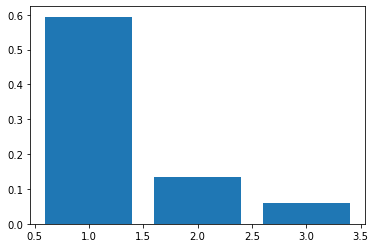

In [181]:
x = df_img.groupby('prediction_level').mean().index
y = df_img.groupby('prediction_level').mean()['confidence']
plt.bar(x,y)
plt.show()

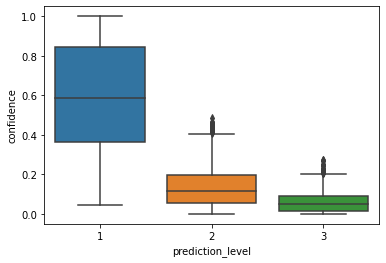

In [233]:
sns.boxplot(x='prediction_level',y='confidence',data=df_img,);

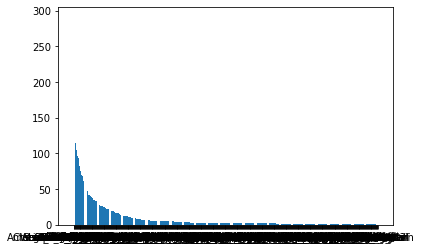

In [184]:
x = df_img.prediction.value_counts().index
y = df_img.prediction.value_counts().values
plt.bar(x,y)
plt.show()

<AxesSubplot:ylabel='breed'>

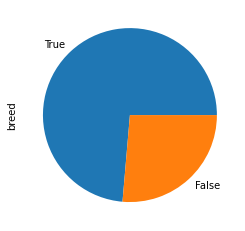

In [189]:
df_img.breed.value_counts().plot(kind='pie')
